In [1]:
library(tidyverse)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


In [2]:
library(ggrepel)
library(DOSE)
library(org.Mm.eg.db)
library(clusterProfiler)
library(enrichplot)
library(msigdbr)



DOSE v3.28.1  For help: https://yulab-smu.top/biomedical-knowledge-mining-book/

If you use DOSE in published research, please cite:
Guangchuang Yu, Li-Gen Wang, Guang-Rong Yan, Qing-Yu He. DOSE: an R/Bioconductor package for Disease Ontology Semantic and Enrichment analysis. Bioinformatics 2015, 31(4):608-609


Loading required package: AnnotationDbi

Loading required package: stats4

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:lubridate’:

    intersect, setdiff, union


The following objects are masked from ‘package:dplyr’:

    combine, intersect, setdiff, union


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
    colnames, dirname, do.call, duplicated, eval, evalq, Filter, Find,
    get, grep, grepl, intersect, is.unsorted, lapply, Map, mappl

In [3]:
setwd(dir = '/home/wpy/stereoseq/20240502-SPACseq')
tab <- read.csv('Group_sgCd44_vs_sginter_DESeq2.txt', sep='\t') %>% drop_na() %>% filter(.$padj < 0.05)

In [4]:
options(repr.plot.width=10,repr.plot.height=9)

tab$color = 'insig'
tab$color[tab$log2FoldChange > 0.5 & tab$padj < 0.01] = 'high'
tab$color[tab$log2FoldChange < -0.5 & tab$padj < 0.01] = 'low'
tab$color = factor(tab$color, levels = c('low','insig','high'))

p <- ggplot(tab, aes(x = log2FoldChange, y = -log10(padj))) +
  geom_point(aes(color=color), size = 1) +
  scale_color_manual(values = c("blue", "grey", "red")) +
  theme_classic()+
  labs(
    title = "sgCd44 ~ sgIntergenic Co-culture",
    x = "Log2 Fold Change",
    y = "-Log10 Adjusted P-Value",
    color = 'Significance'
  ) +
  coord_cartesian(xlim = c(-2,2))+
  geom_hline(yintercept = -log10(0.01), linetype = "dashed", color = "black") +
  geom_vline(xintercept = c(-0.5, 0.5), linetype = "dashed", color = "black") +
  geom_text_repel(
    data = subset(tab, (padj < 0.01) & (abs(log2FoldChange) > 0.5)) | (Gene_name == "Spp1")),,
    aes(label = Gene_name),
    size = 3, max.overlaps = 10 # 调整注释文字的大小和避免重叠
  )

p <- p + theme(
  plot.title = element_text(size = 20, hjust=0.5, vjust=0.3),  # 标题大小
  axis.title = element_text(size = 16),  # 轴标题大小
  axis.text = element_text(size = 12),   # 坐标轴标签大小
  legend.title = element_text(size = 14),
  legend.text = element_text(size = 12)  # 图例文本大小
)

ggsave('co-culture.pdf', p, dpi=600)

Saving 6.67 x 6.67 in image


Warning message:
“ggrepel: 196 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


In [4]:
tab_high <- tab %>% filter(.$log2FoldChange > 0)
tab_low <- tab %>% filter(.$log2FoldChange < 0)

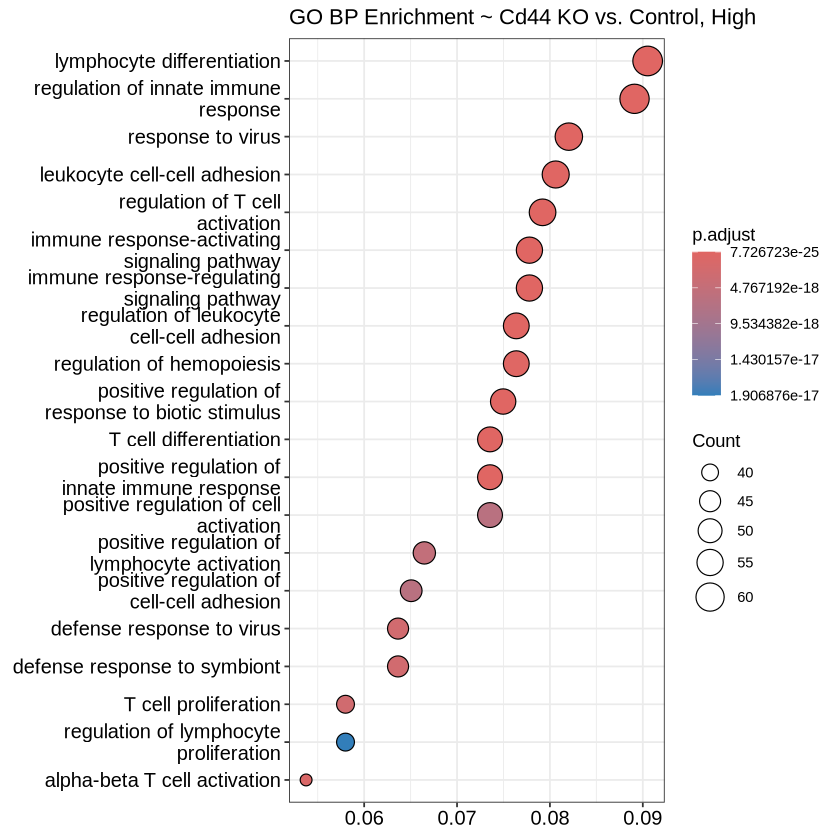

In [14]:
# _df <- msigdbr(species = "Mus musculus", category = "H")
# hallmark_sets <- m_df %>% select(c('gs_name', 'gene_symbol'))
# hallmark_enrich <- enricher(tab_high$Gene_name, TERM2GENE = hallmark_sets, pvalueCutoff = 0.05)

# hallmark_enrich@result$Description <- gsub("HALLMARK_", "", hallmark_enrich@result$Description)
# hallmark_enrich@result$color <- ifelse(hallmark_enrich@result$Description %in% c('EPITHELIAL_MESENCHYMAL_TRANSITION', 'INTERFERON_ALPHA_RESPONSE', 'INTERFERON_GAMMA_RESPONSE'), 'red', 'black')

# dotplot(hallmark_enrich, showCategory=20) + ggtitle("Hallmark Enrichment ~ Cd44 KO vs. Control") +
# theme(axis.title.x = element_blank(),  # 去除 x 轴标签
#       axis.title.y = element_blank())  # 去除 y 轴标签

go_enrich <- enrichGO(
  gene          = tab_high$Gene_name,
  OrgDb         = org.Mm.eg.db,  # 使用小鼠的基因数据库
  keyType       = "SYMBOL",      # 基因列表中的基因是符号形式
  ont           = "BP",          # 使用Biological Process
  pAdjustMethod = "BH",          # 使用Benjamini-Hochberg方法校正p值
  pvalueCutoff  = 0.05,          # p值阈值
  qvalueCutoff  = 0.05,          # q值阈值
  readable      = TRUE            # 将结果转换为更具可读性的基因名称
)

# 查看富集结果
# print(go_enrich)

# 如果有特定的条目需要标记颜色，可以像之前一样修改描述字段
# go_enrich@result$color <- ifelse(go_enrich@result$Description %in% c('apoptotic process', 'cell cycle', 'immune response'), 'red', 'black')

# 绘制富集分析结果的dotplot
dotplot(go_enrich, showCategory=20) + 
  ggtitle("GO BP Enrichment ~ Cd44 KO vs. Control, High") +
  theme(axis.title.x = element_blank(),  # 去除 x 轴标签
        axis.title.y = element_blank())  # 去除 y 轴标签

In [15]:
write.table(go_enrich@result, 'high.csv', sep='\t', quote=F)

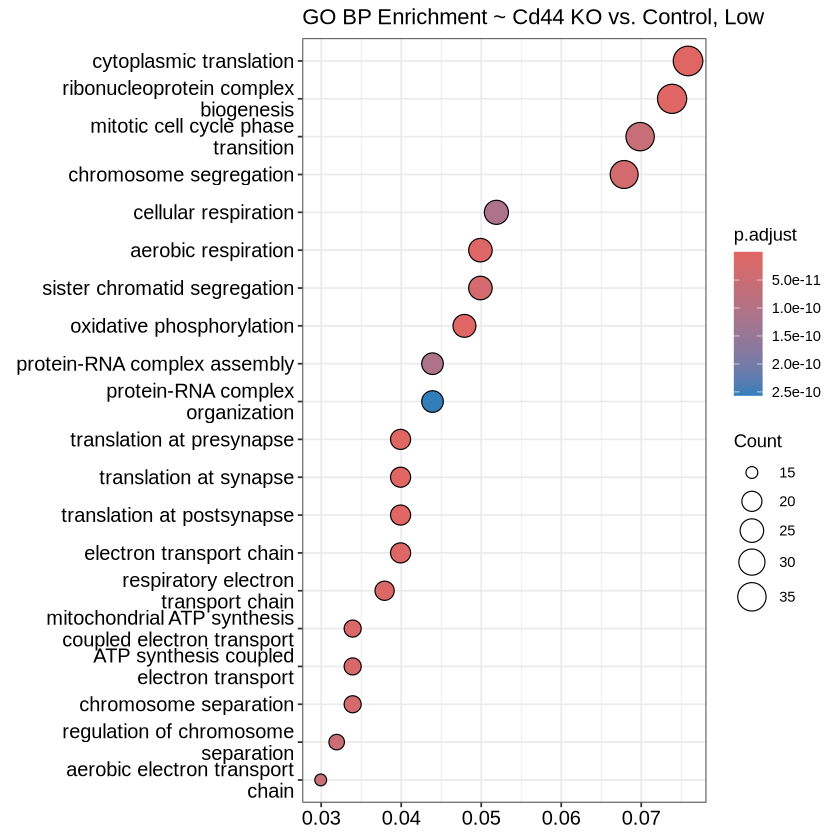

In [6]:
# _df <- msigdbr(species = "Mus musculus", category = "H")
# hallmark_sets <- m_df %>% select(c('gs_name', 'gene_symbol'))
# hallmark_enrich <- enricher(tab_high$Gene_name, TERM2GENE = hallmark_sets, pvalueCutoff = 0.05)

# hallmark_enrich@result$Description <- gsub("HALLMARK_", "", hallmark_enrich@result$Description)
# hallmark_enrich@result$color <- ifelse(hallmark_enrich@result$Description %in% c('EPITHELIAL_MESENCHYMAL_TRANSITION', 'INTERFERON_ALPHA_RESPONSE', 'INTERFERON_GAMMA_RESPONSE'), 'red', 'black')

# dotplot(hallmark_enrich, showCategory=20) + ggtitle("Hallmark Enrichment ~ Cd44 KO vs. Control") +
# theme(axis.title.x = element_blank(),  # 去除 x 轴标签
#       axis.title.y = element_blank())  # 去除 y 轴标签

go_enrich <- enrichGO(
  gene          = tab_low$Gene_name,
  OrgDb         = org.Mm.eg.db,  # 使用小鼠的基因数据库
  keyType       = "SYMBOL",      # 基因列表中的基因是符号形式
  ont           = "BP",          # 使用Biological Process
  pAdjustMethod = "BH",          # 使用Benjamini-Hochberg方法校正p值
  pvalueCutoff  = 0.05,          # p值阈值
  qvalueCutoff  = 0.05,          # q值阈值
  readable      = TRUE            # 将结果转换为更具可读性的基因名称
)

# 查看富集结果
# print(go_enrich)

# 如果有特定的条目需要标记颜色，可以像之前一样修改描述字段
# go_enrich@result$color <- ifelse(go_enrich@result$Description %in% c('apoptotic process', 'cell cycle', 'immune response'), 'red', 'black')

# 绘制富集分析结果的dotplot
dotplot(go_enrich, showCategory=20) + 
  ggtitle("GO BP Enrichment ~ Cd44 KO vs. Control, Low") +
  theme(axis.title.x = element_blank(),  # 去除 x 轴标签
        axis.title.y = element_blank())  # 去除 y 轴标签

In [26]:
# 假设您的DESeq2结果存储在一个数据框'deseq_results'
deseq_results <- tab[order(tab$log2FoldChange, decreasing = TRUE), ]

# 创建geneList向量，用log2FoldChange值对基因排序
geneList <- deseq_results$log2FoldChange
names(geneList) <- deseq_results$Gene_name

# 查看geneList
head(geneList)

Gm45799    Slfn5     Hcn3  Trim30d     Selp   Ifi208 
4.594727 1.723460 1.713796 1.547118 1.474450 1.402385

In [42]:
# 使用GSEA进行分析，假设您使用GO生物过程（BP）进行富集分析
gsea_results <- gseGO(
  geneList = geneList,
  OrgDb = org.Mm.eg.db,  # 或者使用适合您的物种，如小鼠：org.Mm.eg.db
  keyType = "SYMBOL",      # 基因列表中的基因是符号形式
  ont = "BP",
  minGSSize = 10,
  maxGSSize = 500,
  pvalueCutoff = 0.05,
  verbose = FALSE
)

# 查看GSEA结果，包括NES
head(gsea_results@result)

,ID,Description,setSize,enrichmentScore,NES,pvalue,p.adjust,qvalue,rank,leading_edge,core_enrichment
,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
GO:0002218,GO:0002218,activation of innate immune response,44,0.6095462,2.955033,4.297472e-10,3.223530e-07,2.862195e-07,326,"tags=73%, list=25%, signal=56%",Trim30d/Ifi208/Irf7/Ifi206/Oas3/Trim30a/Dhx58/Oas1a/Rsad2/Klrc1/Ifi213/Klrk1/Ifi204/Oasl1/Ifi214/Zbp1/Ifi209/Slc15a3/Ptprs/Unc93b1/Ifih1/Gm12250/Trim25/Klrd1/Eif2ak2/Rftn1/Igtp/Traf3/Gbp5/Trim12c/Tirap/Irf4
GO:0034097,GO:0034097,response to cytokine,128,0.4341552,2.761675,5.272951e-10,3.223530e-07,2.862195e-07,318,"tags=49%, list=25%, signal=41%",Selp/Ifi208/Irf7/Gbp10/Sell/Ifit1/Ifi206/Oas3/Oasl2/Oas1a/Pml/9930111J21Rik1/Ifi213/Ifi204/Oasl1/Gbp9/Xaf1/Ripor2/Ifi214/Zbp1/Sp100/Ifi209/Shfl/Ccr7/Adar/Egln3/Isg15/Osm/Stat1/Gbp6/Gbp4/Pdgfb/Prkca/Il12rb2/Notch1/Parp14/Enah/Nefh/Ifih1/Fasn/Stat5a/Trim25/Il10ra/Jak3/Tgtp2/Il3/Eif2ak2/Sbno2/Il12rb1/Il27ra/Daxx/Trim56/Il4ra/Igtp/Traf3/Gbp5/Stat4/Hdac4/Il21r/Socs3/Ext1/Myc/Gsn
GO:0006952,GO:0006952,defense response,227,0.3587754,2.517524,4.275464e-10,3.223530e-07,2.862195e-07,328,"tags=44%, list=25%, signal=40%",Trim30d/Selp/Ifi208/Irf7/Lrsam1/Gbp10/Ifit1/Ifi206/Oas3/Mx1/Trim30a/Oasl2/Dhx58/Oas1a/Pml/Rsad2/Slfn8/Rtp4/9930111J21Rik1/Klrc1/Ifi213/Klrk1/Ifi204/Oasl1/Ccr4/Gbp9/Ifi214/Cd6/Zbp1/Sp100/Ifi209/Shfl/Ccr7/Tagap/Slc15a3/Rnf213/Adar/Isg15/Osm/Stat1/Gbp6/Gbp4/Daglb/Prkca/Notch1/Chst2/Trim34a/Adam15/Parp14/Herc6/Ptprs/Bcl3/Unc93b1/Lgals9/Ikbkg/Lag3/Ifih1/Ly9/Fasn/Gm12250/Rnf31/Stat5a/Trim25/Il10ra/Tnfrsf4/Jak3/Brd4/Tgtp2/Klrd1/Sp110/Sema7a/Eif2ak2/Sbno2/Il12rb1/Il27ra/Daxx/Rftn1/Trim56/Tap1/Trafd1/Il4ra/Igtp/Kdm6b/Plekhm2/Tnfsf8/Notch2/Traf3/Gbp5/Stat4/Hps1/Hdac4/Trim12c/Socs3/Tirap/Ext1/Il10/Gsn/Slamf1/Irf4/Zeb2
GO:0071345,GO:0071345,cellular response to cytokine stimulus,112,0.4479565,2.750922,1.136059e-09,3.472552e-07,3.083303e-07,318,"tags=51%, list=25%, signal=42%",Selp/Ifi208/Irf7/Gbp10/Ifit1/Ifi206/Oas3/Oasl2/Oas1a/Pml/9930111J21Rik1/Ifi213/Ifi204/Oasl1/Gbp9/Ripor2/Ifi214/Zbp1/Ifi209/Ccr7/Adar/Egln3/Isg15/Osm/Stat1/Gbp6/Gbp4/Pdgfb/Il12rb2/Notch1/Parp14/Enah/Nefh/Ifih1/Fasn/Stat5a/Trim25/Il10ra/Jak3/Tgtp2/Il3/Sbno2/Il12rb1/Il27ra/Daxx/Trim56/Il4ra/Igtp/Traf3/Gbp5/Stat4/Hdac4/Il21r/Socs3/Ext1/Myc/Gsn
GO:0043207,GO:0043207,response to external biotic stimulus,202,0.3659932,2.507598,9.522820e-10,3.472552e-07,3.083303e-07,326,"tags=44%, list=25%, signal=39%",Trim30d/Ifi208/Cmpk2/Irf7/Lrsam1/Gbp10/Ifit1/Ifi206/Oas3/Mx1/Trim30a/Oasl2/Usp18/Dhx58/Oas1a/Pml/Rsad2/Slfn8/Rtp4/Klrc1/Ifi213/Klrk1/Ifi204/Oasl1/Gbp9/Ifi214/Cd6/Zbp1/Sp100/Ifi209/Shfl/Ccr7/Tagap/Slc15a3/Rnf213/Adar/Slfn2/Isg15/Stat1/Gbp6/Gbp4/Ifi27l2a/Prkca/Il12rb2/Trim34a/Adam15/Parp14/Herc6/Ptprs/Bcl3/Unc93b1/Lgals9/Ikbkg/Lag3/Ifih1/Ly9/Pou2f2/Gm12250/Rnf31/Stat5a/Trim25/Jak3/Tgtp2/Klrd1/Sp110/Eif2ak2/Sbno2/Il12rb1/Il27ra/Daxx/Rftn1/Trim56/Tap1/Trafd1/Il4ra/Igtp/Plekhm2/Tnfsf8/Notch2/Traf3/Gbp5/Hdac4/Trim12c/Tirap/Ext1/Il10/Gsn/Slamf1/Irf4
GO:0051707,GO:0051707,response to other organism,202,0.3659932,2.507598,9.522820e-10,3.472552e-07,3.083303e-07,326,"tags=44%, list=25%, signal=39%",Trim30d/Ifi208/Cmpk2/Irf7/Lrsam1/Gbp10/Ifit1/Ifi206/Oas3/Mx1/Trim30a/Oasl2/Usp18/Dhx58/Oas1a/Pml/Rsad2/Slfn8/Rtp4/Klrc1/Ifi213/Klrk1/Ifi204/Oasl1/Gbp9/Ifi214/Cd6/Zbp1/Sp100/Ifi209/Shfl/Ccr7/Tagap/Slc15a3/Rnf213/Adar/Slfn2/Isg15/Stat1/Gbp6/Gbp4/Ifi27l2a/Prkca/Il12rb2/Trim34a/Adam15/Parp14/Herc6/Ptprs/Bcl3/Unc93b1/Lgals9/Ikbkg/Lag3/Ifih1/Ly9/Pou2f2/Gm12250/Rnf31/Stat5a/Trim25/Jak3/Tgtp2/Klrd1/Sp110/Eif2ak2/Sbno2/Il12rb1/Il27ra/Daxx/Rftn1/Trim56/Tap1/Trafd1/Il4ra/Igtp/Plekhm2/Tnfsf8/Notch2/Traf3/Gbp5/Hdac4/Trim12c/Tirap/Ext1/Il10/Gsn/Slamf1/Irf4


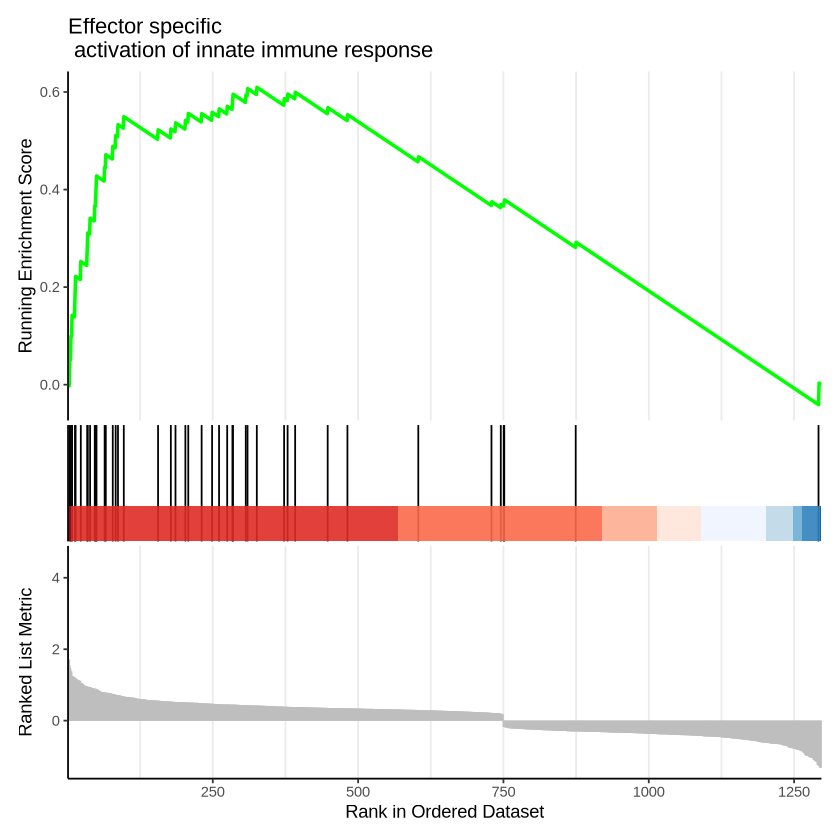

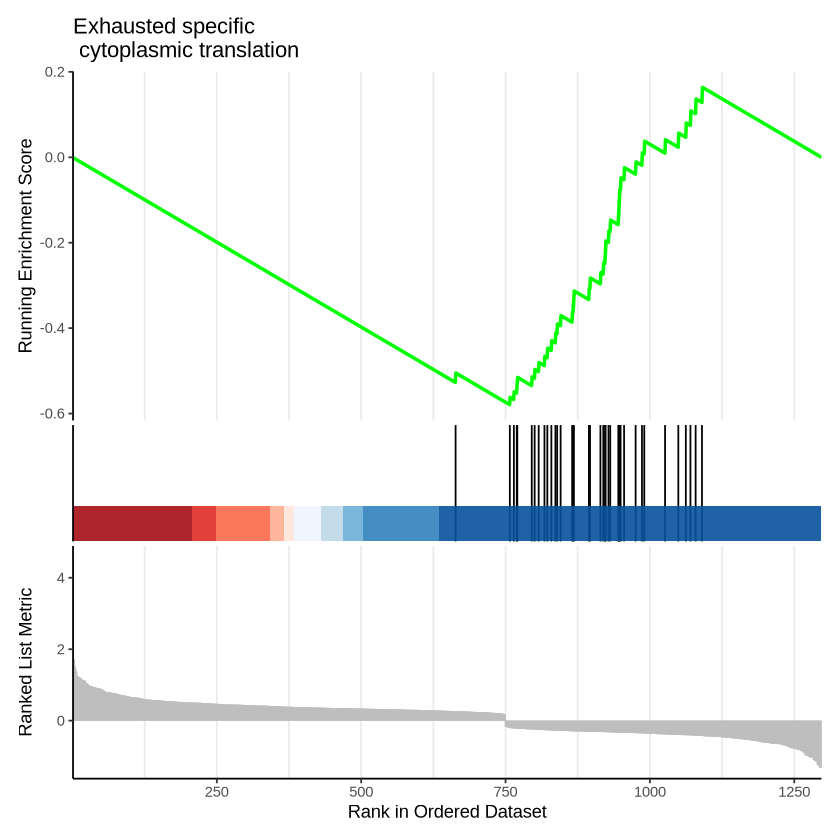

In [47]:
# 找到L2FC最大的pathway
max_l2fc_pathway <- gsea_results@result[which.max(gsea_results$NES), ]

# 找到L2FC最小的pathway
min_l2fc_pathway <- gsea_results@result[which.min(gsea_results$NES), ]

# 绘制L2FC最大的pathway的GSEA图
p1 <- gseaplot2(
  gsea_results,
  geneSetID = max_l2fc_pathway$ID,
  title = paste("Effector specific\n", max_l2fc_pathway$Description),
  color = "green"
)

# 绘制L2FC最小的pathway的GSEA图
p2 <- gseaplot2(
  gsea_results,
  geneSetID = min_l2fc_pathway$ID,
  title = paste("Exhausted specific\n", min_l2fc_pathway$Description),
  color = "green"
)

# 合并两个图像并保存
print(p1)
print(p2)

# 保存为PDF文件
# ggsave("gsea_plots.pdf", plot = gridExtra::grid.arrange(p1, p2, ncol=2), width = 14, height = 7)


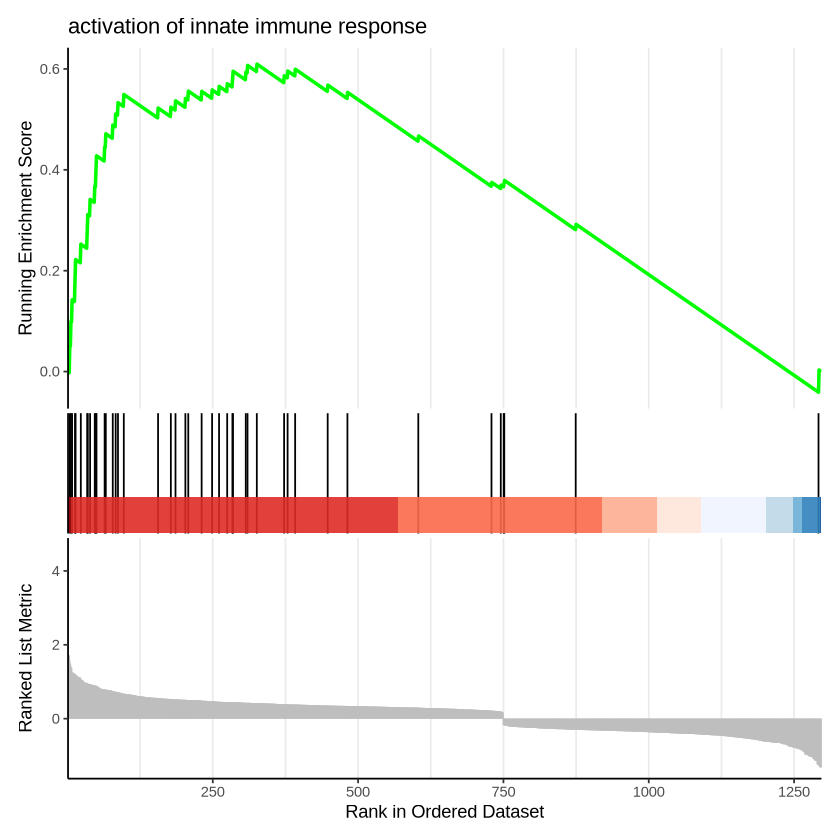

In [29]:
gseaplot2(gsea_results, geneSetID = gsea_results@result$ID[1], title = gsea_results@result$Description[1])

In [38]:
gseaplot2(gsea_results, geneSetID = gsea_results@result$ID[2], title = gsea_results@result$Description[2])

ERROR: Error in gsea_results@result: no applicable method for `@` applied to an object of class "data.frame"


In [13]:
write.table(go_enrich@result, 'down.csv', sep='\t', quote=F)

In [23]:
geneList <- tab_high$log2FoldChange
names(geneList) <- tab_high$Gene_name

geneList <- geneList %>% sort(decreasing=TRUE)
head(geneList)

Gm45799    Slfn5     Hcn3  Trim30d     Selp   Ifi208 
4.594727 1.723460 1.713796 1.547118 1.474450 1.402385

preparing geneSet collections...

GSEA analysis...

Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“All values in the stats vector are greater than zero and scoreType is "std", maybe you should switch to scoreType = "pos".”
Warning message in fgseaMultilevel(pathways = pathways, stats = stats, minSize = minSize, :
“There were 9 pathways for which P-values were not calculated properly due to unbalanced (positive and negative) gene-level statistic values. For such pathways pval, padj, NES, log2err are set to NA. You can try to increase the value of the argument nPermSimple (for example set it nPermSimple = 10000)”
Warning message in fgseaMultilevel(pathways = pathways, stats = stats, minSize = minSize, :
“For some of the pathways the P-values were likely overestimated. For such pathways log2err is set to NA.”
leading edge analysis...

done...



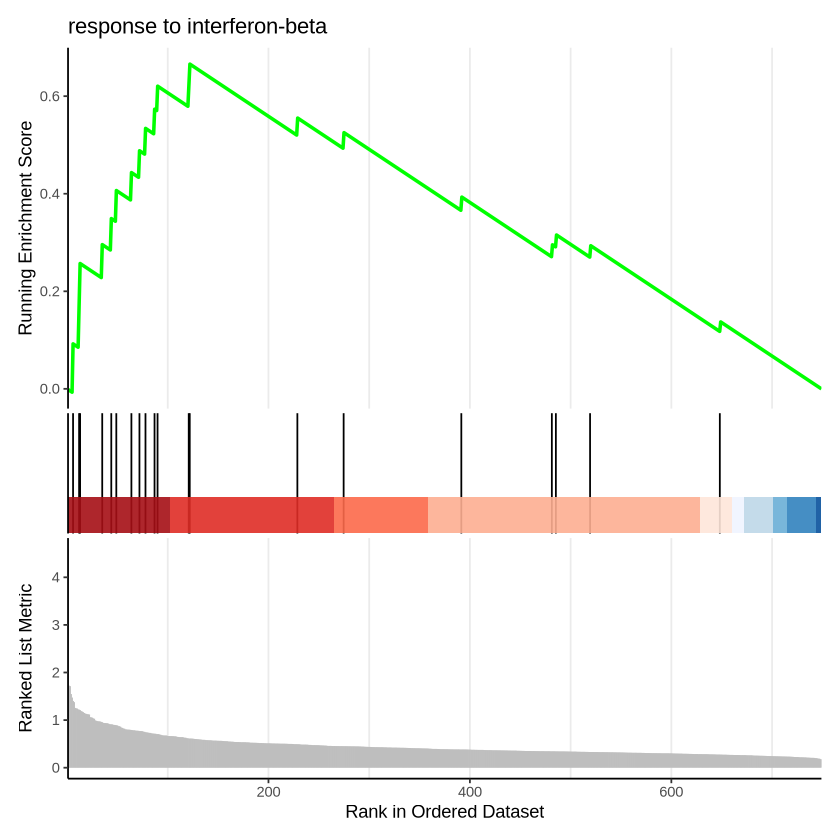

In [26]:
gsea_result <- gseGO(geneList = geneList, 
                     OrgDb = org.Mm.eg.db, 
                     ont = "BP", 
                     keyType = "SYMBOL",
                     minGSSize = 10, 
                     maxGSSize = 500, 
                     pvalueCutoff = 0.05, 
                     verbose = TRUE)

gseaplot2(gsea_result, geneSetID = gsea_result@result$ID[1], title = gsea_result@result$Description[1])

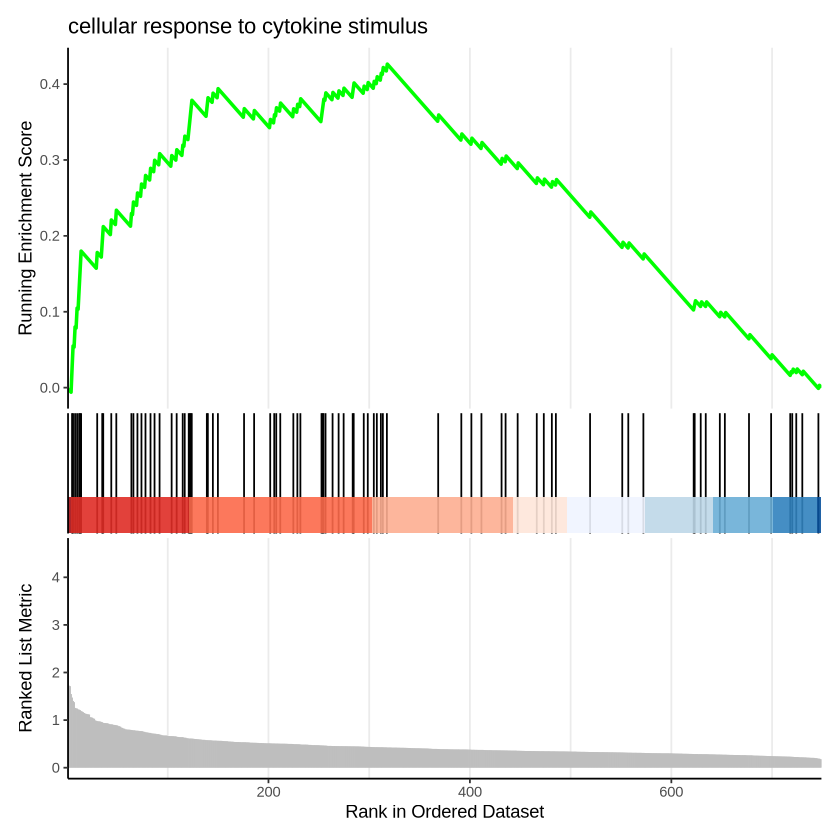

In [37]:
gseaplot2(gsea_result, geneSetID = gsea_result@result$ID[11], title = gsea_result@result$Description[11])

In [38]:
geneList <- tab_low$log2FoldChange
names(geneList) <- tab_low$Gene_name

geneList <- geneList %>% sort(decreasing=TRUE)
head(geneList)

Top2a    Csnk1a1     Havcr2       Cct4       Scd2    Tnfsf11 
-0.1704795 -0.1752146 -0.1824002 -0.1889301 -0.1897579 -0.1926670

preparing geneSet collections...

GSEA analysis...

Warning message in fgseaMultilevel(pathways = pathways, stats = stats, minSize = minSize, :
“There were 28 pathways for which P-values were not calculated properly due to unbalanced (positive and negative) gene-level statistic values. For such pathways pval, padj, NES, log2err are set to NA. You can try to increase the value of the argument nPermSimple (for example set it nPermSimple = 10000)”
leading edge analysis...

done...



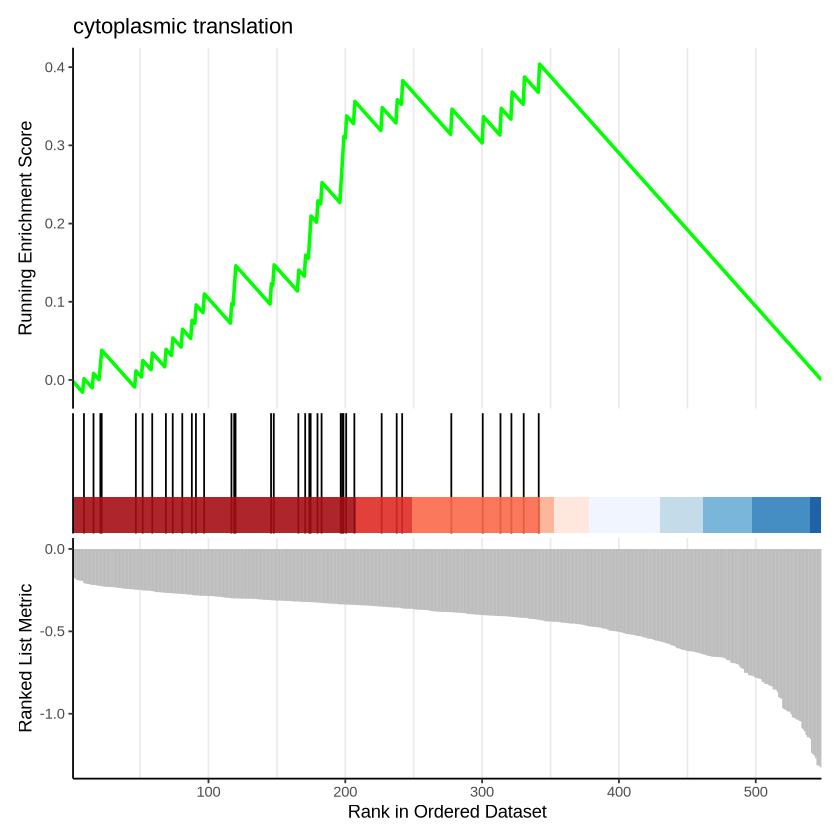

In [39]:
gsea_result_ <- gseGO(geneList = geneList, 
                     OrgDb = org.Mm.eg.db, 
                     ont = "BP", 
                     keyType = "SYMBOL",
                     minGSSize = 10, 
                     maxGSSize = 500, 
                     pvalueCutoff = 0.05, 
                     verbose = TRUE)

gseaplot2(gsea_result_, geneSetID = gsea_result_@result$ID[1], title = gsea_result_@result$Description[1])